In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
from itertools import product

# preprocessing
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# handling detection
from sklearn.ensemble import IsolationForest

# imbalanced data 
from imblearn.over_sampling import SMOTE, SMOTENC

# models
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# hyper-parameter tunning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer


# evaluation
from sklearn.metrics import\
    accuracy_score, confusion_matrix, classification_report, \
    f1_score, recall_score, balanced_accuracy_score, precision_score

# storing the best model
import pickle


/Users/artmissg/anaconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option('display.max_columns', 30)  # Adjust the number as needed

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 


> notes :  
    - ❌ convert N_Days to 3 groups based on if there status, for example if the patient has died or ... 
    - ✅ convert Age from days to years ?
    - the target labels, you actually divide them into two main groups, Survived / Dead . because groups CL and C represent survived people
    - add additional features based on the notebook on kaggle
    - new features based on whether the patient is in the normal range of a feature or not
    - ✅ use the more complete dataset

- outliers
    - you can still work on `Bilirubin` 
    
    
>  the given data is already preprocessed and the missing values are filled with the average of others

C  -> alive at N days  
CL -> alive at N days due to liver transplant  
D  -> dead at N days  

In [3]:
train_data = pd.read_csv("../data/train.csv").drop(columns=["id"])
train_data2 = pd.read_csv("../data/Cir.csv").drop(columns=["ID"]) # original data
data = pd.concat(objs=[train_data, train_data2]).reset_index(drop=True)

from src.pipelines import pipeline, basic_pipeline
data = basic_pipeline.fit_transform(data)
data = pipeline.fit_transform(data)


___

# Preprocess

In [9]:
# Detect duplicate rows
duplicates = data.duplicated()
duplicates.sum()

0

#### imputation

In [10]:
# remove Nan Values (the original dataset that we added contains Nan values)
data.isna().sum()

N_years            0
Age                0
is_male            0
Ascites            0
Hepatomegaly       0
Spiders            0
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
Status             0
took_drug          0
dtype: int64

In [33]:
# drop features that contain little Nan values
not_nan_rows = data[["Prothrombin", "Stage", "Platelets"]].dropna().index.to_numpy()
data = data.iloc[not_nan_rows, :]

In [34]:
# analyse the rest of columns
features = data.columns[data.isna().sum() != 0].to_numpy()
features

array(['Cholesterol', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides'],
      dtype=object)

In [35]:
data[features].isna().iloc[-10:8322]

,Cholesterol,Copper,Alk_Phos,SGOT,Tryglicerides
8313,True,True,True,True,True
8314,True,True,True,True,True
8315,True,True,True,True,True
8316,True,True,True,True,True
8317,True,True,True,True,True
8318,True,True,True,True,True
8319,True,True,True,True,True
8320,True,True,True,True,True
8321,True,True,True,True,True
8322,True,True,True,True,True


the latest samples have too many Nan values each, so let's remove samples with too many Nan features

In [36]:
data.iloc[8217, :]

N_years           3.205479
Age              61.041096
is_male                1.0
Ascites                  0
Hepatomegaly             0
Spiders                  0
Edema                    S
Bilirubin              1.3
Cholesterol            NaN
Albumin               3.41
Copper                 NaN
Alk_Phos               NaN
SGOT                   NaN
Tryglicerides          NaN
Platelets            259.0
Prothrombin           10.9
Stage                  4.0
Status                   0
took_drug                0
Name: 8225, dtype: object

In [37]:
data.iloc[21, :].name

21

In [38]:
# a function that returns the count of Nan in each row
def count_nan(data, index_range: int, threshhold:int=3) :
    '''checks the last X samples for their number of Nan values where X is `index_range`'''
    indexes = []
    n = data.shape[0]
    for row in data.iloc[-index_range: ,:].iterrows() :
        row_ind, row = row # it's a tuple
    # for row_ind in range(n-index_range, n) :
        row_ind = row.name
        row_nan_values = row[row.isna()]
        if len(row_nan_values) >= threshhold :
            indexes.append(row_ind)
            
    return indexes
indexes = count_nan(data, 200)
data = data.drop(indexes) 

In [39]:
data.isna().sum()

N_years           0
Age               0
is_male           0
Ascites           0
Hepatomegaly      0
Spiders           0
Edema             0
Bilirubin         0
Cholesterol      28
Albumin           0
Copper            2
Alk_Phos          0
SGOT              0
Tryglicerides    30
Platelets         0
Prothrombin       0
Stage             0
Status            0
took_drug         0
dtype: int64

the rest of Nan values are still little, we can impute them by their mean or just drop them

In [40]:
# impute by the mean 
data.fillna(data.select_dtypes(["int", "float"]).mean(), inplace=True)

#### outliers

In [41]:
# reset the indexes 
data.reset_index(inplace=True)

In [45]:
# outlier removal 
# IsolationForest
### outliers
def single_outlier_removal(column: pd.DataFrame, n_estimators=100, contamination="auto") :
    # single feature
    isolation_forest =IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, max_features=1)
    isolation_forest.fit(column)

    tmp_df = column.copy()
    tmp_df["anomaly"] = isolation_forest.predict(column)
    tmp_df = tmp_df.query("anomaly == 1")
    tmp_df.drop(columns="anomaly", inplace=True)
    return tmp_df

outlier_list = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
chosen_indexes = set()
for feature in data[outlier_list] :
    new = single_outlier_removal(data[[feature]])
    indexes = new.index.tolist()
    chosen_indexes = set(indexes) if not chosen_indexes else chosen_indexes
    chosen_indexes = chosen_indexes.intersection(set(indexes))
new_data = data.iloc[list(chosen_indexes), :]

In [46]:
data.shape

(8213, 20)

In [47]:
new_data.shape

(1430, 20)

##### small eda

In [51]:
new_data = new_data.reset_index()

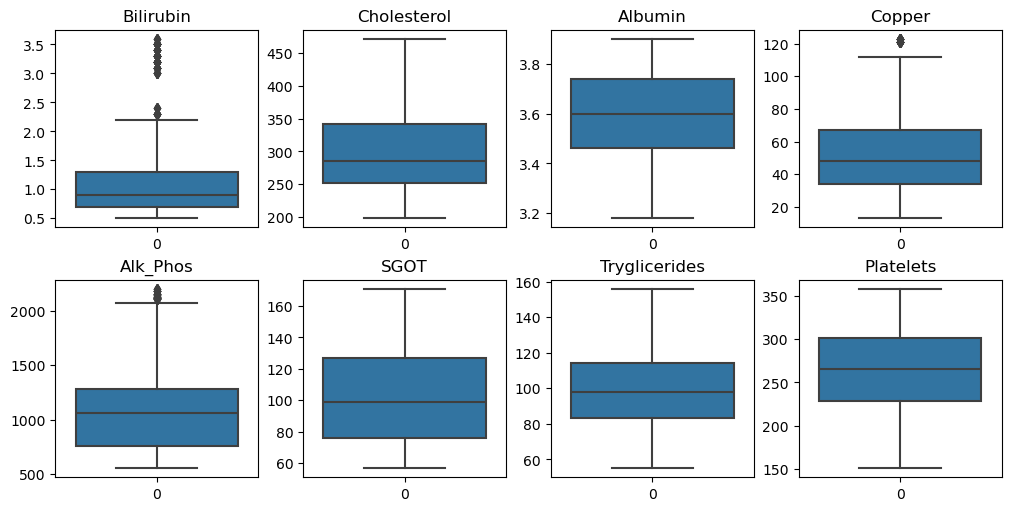

In [52]:
def box_plotter(df, features=None) :
    fig_x = 2
    fig_y = 4
    fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")
    df = df.select_dtypes(["int", "float"]) if features==None else df.select_dtypes(["int", "float"])[features]
    for index, column in zip(product(range(fig_x), range(fig_y)), df) :
        sns.boxplot(
            df[column],
            ax=axes[index[0], index[1]],
        )
        axes[index[0], index[1]].set_title(column)

box_plotter(new_data, outlier_list)

some features still seem to have outliers? :

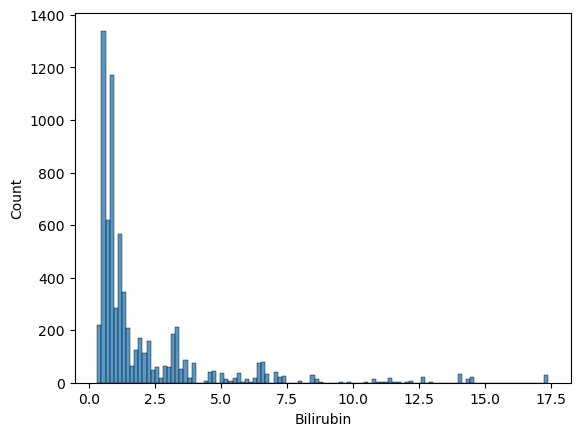

In [109]:
sns.histplot(
    new_data,
    x="Bilirubin"
);

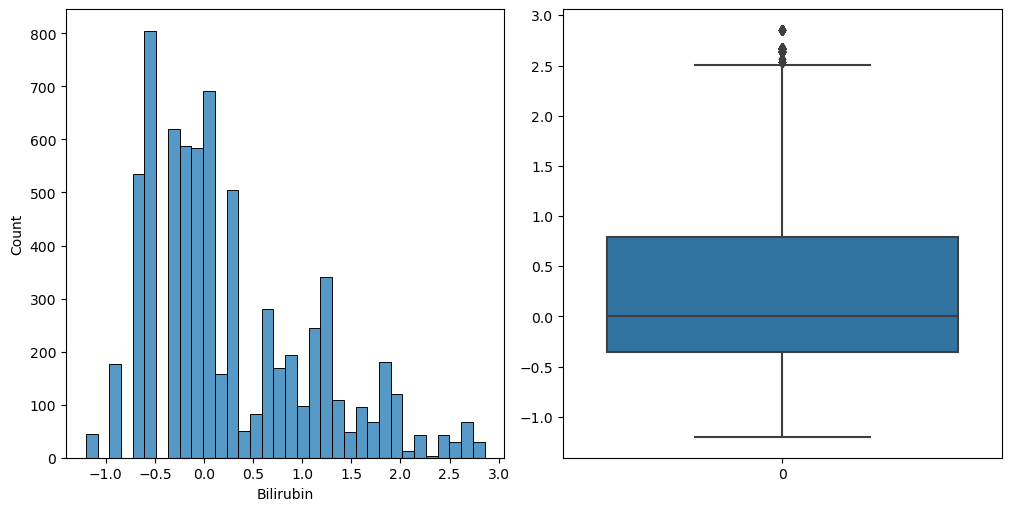

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")

sns.histplot(
    np.log(new_data["Bilirubin"]),
    ax=axes[0]
);
sns.boxplot(
    np.log(new_data["Bilirubin"]),
    ax=axes[1]
);

it seems that applying `log` transformation makes this features really good, let's check others too :

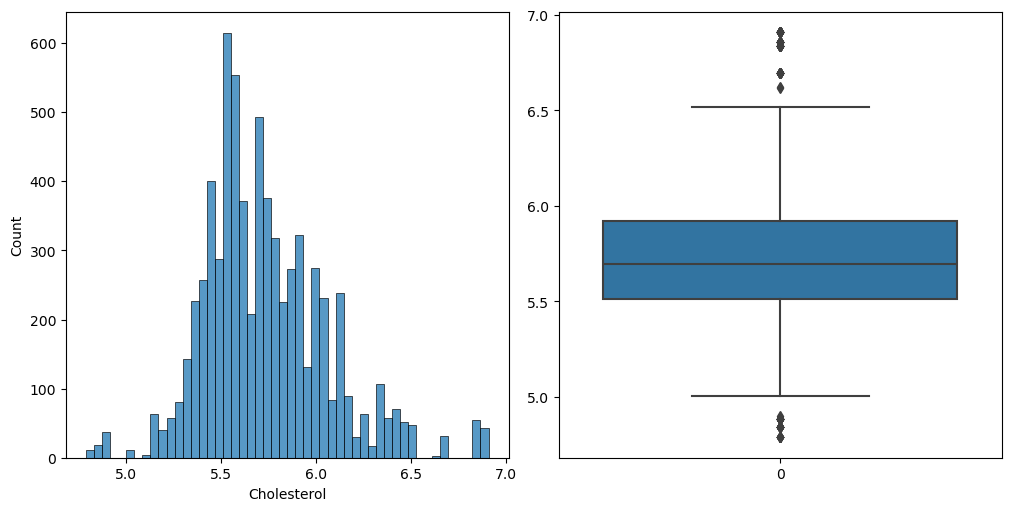

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")

sns.histplot(
    np.log(new_data["Cholesterol"]),
    ax=axes[0]
);
sns.boxplot(
    np.log(new_data["Cholesterol"]),
    ax=axes[1]
);

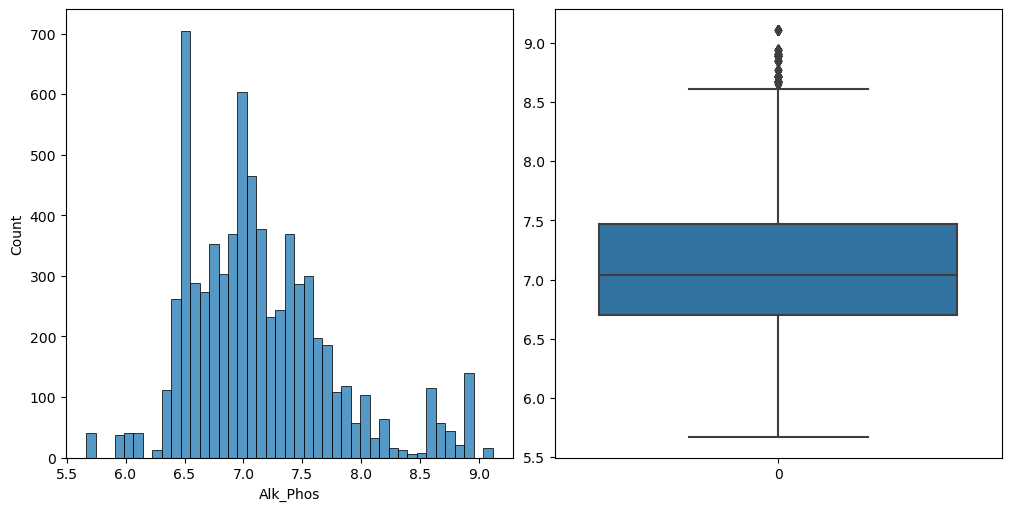

In [114]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")

sns.histplot(
    np.log(new_data["Alk_Phos"]),
    ax=axes[0]
);
sns.boxplot(
    np.log(new_data["Alk_Phos"]),
    ax=axes[1]
);

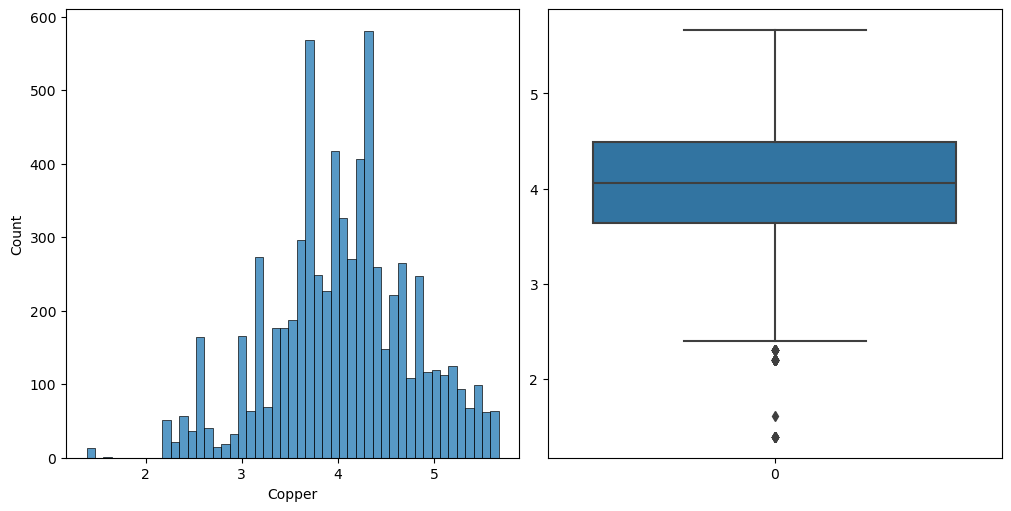

In [115]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), layout="constrained")

sns.histplot(
    np.log(new_data["Copper"]),
    ax=axes[0]
);
sns.boxplot(
    np.log(new_data["Copper"]),
    ax=axes[1]
);

looks perfect, let's apply it to the data:

##### log transformation

In [117]:
new_data["Bilirubin"] = np.log(data["Bilirubin"]) 
new_data["Copper"] = np.log(data["Copper"])
new_data["Alk_Phos"] = np.log(data["Alk_Phos"])
new_data["Cholesterol"] = np.log(data["Cholesterol"])

___

In [8]:
data.head()

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug
0,2.736986,58.991781,1.0,0,0,0,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,2,1
1,7.052055,52.704110,0.0,0,0,0,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,0,0
2,9.391781,37.608219,0.0,0,1,1,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,2,0
3,7.057534,50.575342,0.0,0,0,0,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,0
4,2.158904,45.638356,0.0,0,1,0,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,0


In [78]:
### outliers
def single_outlier_removal(column: pd.DataFrame, n_estimators=50, contamination=0.03) :
    # single feature
    isolation_forest =IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, max_features=1)
    isolation_forest.fit(column)

    tmp_df = column.copy()
    tmp_df["anomaly"] = isolation_forest.predict(column)
    tmp_df = tmp_df.query("anomaly == 1")
    tmp_df.drop(columns="anomaly", inplace=True)
    return tmp_df

outlier_list = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
chosen_indexes = set()
for feature in data[outlier_list] :
    new = single_outlier_removal(data[[feature]])
    indexes = new.index.tolist()
    chosen_indexes = set(indexes) if not chosen_indexes else chosen_indexes
    chosen_indexes = chosen_indexes.intersection(set(indexes))
new_data = data.iloc[list(chosen_indexes), :]

#### SMOTE

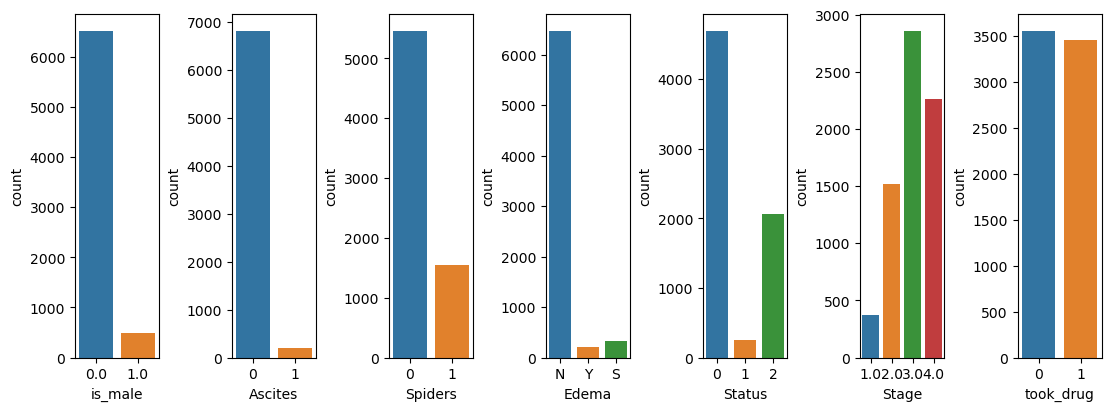

In [118]:
### categorical imbalanced data
imbalanced_list = ["is_male", "Ascites", "Spiders", "Edema", "Status", "Stage", "took_drug"]

fig, axes = plt.subplots(1, 7, figsize=(11, 4), layout="constrained")
for index, column in enumerate(imbalanced_list):
    sns.countplot(
        new_data,
        x=column,
        ax=axes[index],
    )
    


In [9]:
# using SMOTE for `Stage` and `Spiders` feature
sm = SMOTE(random_state=9090)
smote_nc = SMOTENC(categorical_features=imbalanced_list, random_state=9090)
# smote_nc = SMOTE(random_state=9090)
X, y = smote_nc.fit_resample(new_data.drop(columns=["Status", "Edema"]), new_data["Status"])

NameError: name 'imbalanced_list' is not defined

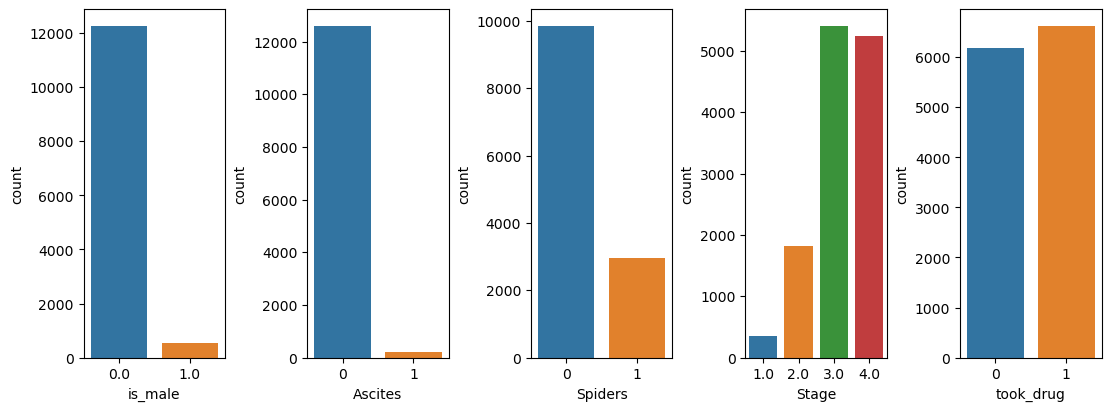

In [115]:
### categorical imbalanced data
imbalanced_list = ["is_male", "Ascites", "Spiders", "Stage", "took_drug"]

fig, axes = plt.subplots(1, 5, figsize=(11, 4), layout="constrained")
for index, column in enumerate(imbalanced_list):
    sns.countplot(
        X,
        x=column,
        ax=axes[index],
    )
    


In [113]:
X["is_male"].value_counts()

is_male
0.0    12266
1.0      550
Name: count, dtype: int64

In [114]:
new_data["is_male"].value_counts()

is_male
0.0    5833
1.0     416
Name: count, dtype: int64

The results are not satisfiable, it only makes it worse!  
so we should try other methods

In [109]:
X

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,took_drug
0,2.736986,58.991781,1.0,0,0,0,2.300000,316.000000,3.350000,172.000000,1601.000000,179.800000,63.000000,394.000000,9.700000,3.0,1
1,7.052055,52.704110,0.0,0,0,0,0.900000,364.000000,3.540000,63.000000,1440.000000,134.850000,88.000000,361.000000,11.000000,3.0,0
2,9.391781,37.608219,0.0,0,1,1,3.300000,299.000000,3.550000,131.000000,1029.000000,119.350000,50.000000,199.000000,11.700000,4.0,0
3,7.057534,50.575342,0.0,0,0,0,0.600000,256.000000,3.500000,58.000000,1653.000000,71.300000,96.000000,269.000000,10.700000,3.0,0
4,2.158904,45.638356,0.0,0,1,0,1.100000,346.000000,3.650000,63.000000,1181.000000,125.550000,96.000000,298.000000,10.600000,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12811,2.756351,61.005330,0.0,0,1,0,2.685764,261.708280,3.197592,137.437580,1533.000000,118.756162,126.718790,206.762739,11.004745,4.0,0
12812,2.174495,46.947354,0.0,0,0,1,3.247150,312.523313,3.243696,73.523313,1600.051813,159.028503,132.048354,297.683938,11.221071,4.0,0
12813,0.736588,43.809611,0.0,0,0,0,3.391381,260.579287,3.494533,231.097908,1256.681800,130.440282,94.261087,214.592051,10.603264,4.0,0
12814,2.914639,56.451428,0.0,0,1,1,1.400000,180.436614,3.636544,38.599152,1026.399788,123.239270,71.746457,130.600212,11.832720,3.0,0


# Playground

In [7]:
# Function to preprocess the data
def pre_process1(data, inplace=False):
    if not inplace :
        data = data.copy()

    # data.drop(columns=["id"], inplace=True)
    # Convert number of days into years for more clarification
    data["N_Days"] = (data["N_Days"] / 365)
    data.rename(columns={"N_Days": "N_years"}, inplace=True)

    # Some of the users took actual medicine and others didn't
    data["took_drug"] = (data["Drug"] == "D-penicillamine")
    data.drop(columns=["Drug"], inplace=True)

    # Convert age from days into years for more clarification
    data["Age"] = (data["Age"] / 365)
    
    # Fixing boolean features
    data["Sex"] = data["Sex"] == "M"
    data.rename(columns={"Sex": "is_male"}, inplace=True)
    data["Ascites"] = data["Ascites"] == "Y"
    data["Hepatomegaly"] = data["Hepatomegaly"] == "Y"
    data["Spiders"] = data["Spiders"] == "Y"

    # fix True False Features
    data = data.astype(
        {
            "is_male": float,
            "Ascites": int,
            "Spiders": int,
            "took_drug": int,
            "Hepatomegaly": int,
        }
    )
    # data = data.convert_dtypes()
    
    # fixing Status dtype using TargetEncoding
    if "Status" in data.columns :
        encoder = LabelEncoder()
        data["Status"] = encoder.fit_transform(data["Status"])

    return data  # Return the modified DataFrame

def imputation(data, inplace=False):
    if not inplace :
        data = data.copy()
    # drop features that contain little Nan values
    not_nan_rows = data[["Prothrombin", "Stage", "Platelets"]].dropna().index.to_numpy()
    data = data.iloc[not_nan_rows, :]
    # a function that returns the count of Nan in each row
    def count_nan(data, index_range: int, threshhold:int=3) :
        '''checks the last X samples for their number of Nan values where X is `index_range`'''
        indexes = []
        n = data.shape[0]
        for row in data.iloc[-index_range: ,:].iterrows() :
            row_ind, row = row # it's a tuple
        # for row_ind in range(n-index_range, n) :
            row_ind = row.name
            row_nan_values = row[row.isna()]
            if len(row_nan_values) >= threshhold :
                indexes.append(row_ind)
                
        return indexes
    indexes = count_nan(data, 200)
    data = data.drop(indexes) 
    # impute by the mean 
    data.fillna(data.select_dtypes(["int", "float"]).mean(), inplace=True)
    data.reset_index(inplace=True)

    return data

def encode_data(data, inplace=False):
    if not inplace :
        data = data.copy()
        
    encoded_frame = pd.DataFrame(
        OneHotEncoder().fit_transform(data[["Edema"]]).toarray(),
        columns=["no_Edema_no_diuretic", "Edema_no_diuretic", "Edema_diuretic"]
    )
    data = pd.concat(
        [data, encoded_frame],
        axis=1,
    )
    data.drop(columns=["Edema"], inplace=True)



    # # fixing Status dtype using TargetEncoding
    if "Status" in data.columns :
        encoder = LabelEncoder()
        data["Status"] = encoder.fit_transform(data["Status"])


    return data  # Return the modified DataFrame

def scale(data, inplace=False) :
    # scale the data using z-score scaler
    scaler = StandardScaler()
    scaled = scaler.fit_transform(
        data[
            [
                "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
                "Age", "N_years",
            ]
        ]
    )
    data[
        [
            "Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin",
            "Age", "N_years"
        ]
    ] = scaled

    return data

def beta_preprocess(data, inplace=False) :
    if not inplace :
        data = data.copy()
        
    # Isolation Forest
    def single_outlier_removal(column: pd.DataFrame, n_estimators=50, contamination=0.03) :
        # single feature
        isolation_forest =IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, max_features=1)
        isolation_forest.fit(column)

        tmp_df = column.copy()
        tmp_df["anomaly"] = isolation_forest.predict(column)
        tmp_df = tmp_df.query("anomaly == 1")
        tmp_df.drop(columns="anomaly", inplace=True)
        return tmp_df
    outlier_list = ["Bilirubin", "Cholesterol", "Albumin", "Copper", "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]
    chosen_indexes = set()
    for feature in data[outlier_list] :
        new = single_outlier_removal(data[[feature]])
        indexes = new.index.tolist()
        chosen_indexes = set(indexes) if not chosen_indexes else chosen_indexes
        chosen_indexes = chosen_indexes.intersection(set(indexes))
    data = data.iloc[list(chosen_indexes), :]

    # # fixing Status dtype using TargetEncoding
    if "Status" in data.columns :
        encoder = LabelEncoder()
        data["Status"] = encoder.fit_transform(data["Status"])

    return data  # Return the modified DataFrame

# Column Transformer to apply the pre_process function to the entire DataFrame

basic_pipeline = Pipeline(
    [
        ("EDA_preprocessing", FunctionTransformer(func=pre_process1, validate=False)),
    ]
)

pipeline = Pipeline(
    [
        ("EDA_preprocessing", FunctionTransformer(func=pre_process1, validate=False)),
        ("model_preprocessing", FunctionTransformer(func=pre_process2, validate=False)),
    ]
)

beta_pipeline = Pipeline(
    [
        ("EDA_preprocessing", FunctionTransformer(func=pre_process1, validate=False)),
        ("model_preprocessing", FunctionTransformer(func=pre_process2, validate=False)),
        ("beta_preprocess", FunctionTransformer(func=beta_preprocess, validate=False)),
    ]
)

NameError: name 'pre_process2' is not defined

In [7]:
from src.utils import encode_data

final_data = encode_data(data) # ! pay attention that we are encoding `data` and not `new_data`

In [8]:
final_data.shape

(2385, 22)

# Modeling

In [4]:
# Bayesian search using skopt
np.int = np.int_ # fo fix the conflict with python version

opt = BayesSearchCV(
    xgb.XGBClassifier(),
    {
        "n_estimators": Integer(10, 100),
        "max_depth": Integer(5, 50),
        "num_class": Categorical([3]),
        "learning_rate": Real(0.01, 0.4, prior="uniform"),
        "booster": Categorical(["gbtree", "gblinear"]),
        "device": Categorical(["gpu"]),
        # "early_stopping_rounds": Categorical([0, 5, 10, 20]),
        "eval_metric": ['mlogloss'],
    },
    n_iter=32,
    cv=5,
    scoring='accuracy',
    verbose=3,
    random_state=9090,
)

In [6]:
# final_data = train_pipeline.fit_transform(data)
final_data = data.drop(columns=["Edema", "index"])

In [7]:
final_data

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status,took_drug
3,7.057534,50.575342,0.0,0,0,0,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,0,0
4,2.158904,45.638356,0.0,0,1,0,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,0,0
8196,3.619178,31.402740,0.0,0,0,0,0.8,328.0,3.31,62.0,1105.0,137.00,95.0,293.0,10.9,4.0,0,0
6,3.561644,48.501370,0.0,0,0,0,1.0,328.0,3.35,43.0,1677.0,137.95,90.0,291.0,9.8,3.0,0,0
8201,3.547945,45.241096,0.0,0,0,0,1.0,393.0,3.57,50.0,1307.0,74.00,103.0,295.0,10.5,4.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8165,2.969863,46.413699,0.0,0,1,0,3.5,348.0,3.20,121.0,938.0,120.00,146.0,296.0,10.0,4.0,1,0
8170,4.295890,26.295890,0.0,0,1,1,1.0,448.0,3.74,102.0,1128.0,71.00,117.0,228.0,10.2,3.0,0,1
8179,3.926027,56.191781,0.0,0,0,0,0.5,198.0,3.77,38.0,911.0,57.00,56.0,280.0,9.8,2.0,0,0
8185,3.838356,46.380822,0.0,0,0,0,0.8,253.0,3.48,65.0,688.0,57.00,80.0,252.0,10.0,1.0,0,1


In [8]:
from src.pipelines import train_pipeline

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    opt.fit(final_data.drop(columns=["Status"]), final_data['Status'])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END booster=gblinear, device=gpu, eval_metric=mlogloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.830 total time=   0.0s
[CV 2/5] END booster=gblinear, device=gpu, eval_metric=mlogloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.846 total time=   0.0s
[CV 3/5] END booster=gblinear, device=gpu, eval_metric=mlogloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.830 total time=   0.0s
[CV 4/5] END booster=gblinear, device=gpu, eval_metric=mlogloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.830 total time=   0.0s
[CV 5/5] END booster=gblinear, device=gpu, eval_metric=mlogloss, learning_rate=0.12539062470677267, max_depth=39, n_estimators=27, num_class=3;, score=0.836 total time=   0.0s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[C

In [9]:
opt.best_score_

0.8633126934984521

In [10]:
from src.utils import save_model
save_model(opt)

___

In [4]:
from src.utils import load_model
model = load_model("best_model.pkl")

In [11]:
from src.pipelines import test_date_pipeline

In [12]:
data_test = pd.read_csv("../data/test.csv").drop(columns=["id"])
data_test = test_date_pipeline.fit_transform(data_test)
# data_test = encode_data.fit_transform(data_test)

In [13]:
data_test

,N_years,Age,is_male,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,took_drug
0,10.517808,54.038356,0.0,0,1,0,N,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0,1
1,6.761644,41.027397,0.0,0,0,0,N,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0,1
2,0.139726,36.024658,0.0,0,1,0,Y,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0,0
3,6.383562,56.191781,0.0,0,0,0,N,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0,1
4,4.424658,60.010959,0.0,0,1,0,N,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,7.863014,33.641096,0.0,0,0,0,N,1.3,302.0,3.43,75.0,1345.0,145.00,44.0,181.0,10.6,3.0,0
5267,4.849315,67.953425,0.0,0,0,0,N,0.5,219.0,4.09,121.0,663.0,79.05,94.0,311.0,9.7,3.0,0
5268,10.156164,46.547945,0.0,0,1,0,N,0.8,315.0,4.09,13.0,1637.0,170.50,70.0,426.0,10.9,3.0,1
5269,3.331507,32.254795,0.0,0,0,0,N,0.7,329.0,3.80,52.0,678.0,57.00,126.0,306.0,10.2,1.0,0


In [16]:
# predicting using the `model`
X_test = data_test.drop(columns=["Edema"])
# X_test = data_test

model = opt
y_pred = model.predict_proba(X_test)
ans = pd.DataFrame(
    y_pred,
    columns=["Status_C", "Status_CL", "Status_D"]
)
# fixing the id column for the final answer
id_ = pd.read_csv("../data/test.csv")["id"]
ans.insert(0, column="id", value=id_)
ans.to_csv('ans.csv', index=False)

In [17]:
ans

,id,Status_C,Status_CL,Status_D
0,7905,0.803576,0.002769,0.193655
1,7906,0.546138,0.273208,0.180654
2,7907,0.258501,0.007667,0.733832
3,7908,0.981474,0.000281,0.018245
4,7909,0.987946,0.000932,0.011122
...,...,...,...,...
5266,13171,0.980100,0.011555,0.008345
5267,13172,0.987897,0.000283,0.011819
5268,13173,0.968185,0.000401,0.031413
5269,13174,0.999843,0.000085,0.000071


# results

after submitting the model on the test data,  
the error was to high, and it seems that we are `over-fitting`